In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import os

## Preparando os dados com oversampling

In [2]:
df_train = pd.read_csv('train_ground_truth.csv')
categorical = df_train[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1).values
df_train['name'] = df_train['image'].map(lambda x: '{}.jpg'.format(x))
df_train['label'] = categorical
df_train.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'image'], axis=1, inplace=True)
df_train.drop
df_train['is_valid'] = False
del df_train['Unnamed: 0']
df_train.head()

,name,label,is_valid
0,ISIC_0024306.jpg,NV,False
1,ISIC_0024307.jpg,NV,False
2,ISIC_0024308.jpg,NV,False
3,ISIC_0024309.jpg,NV,False
4,ISIC_0024314.jpg,NV,False


In [3]:
df_valid = pd.read_csv('valid_ground_truth.csv')
categorical = df_valid[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1).values
df_valid['name'] = df_valid['image'].map(lambda x: '{}.jpg'.format(x))
df_valid['label'] = categorical
df_valid.drop(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'image'], axis=1, inplace=True)
df_valid.drop
df_valid['is_valid'] = True
del df_valid['Unnamed: 0']
df_valid.head()

,name,label,is_valid
0,ISIC_0027832.jpg,MEL,True
1,ISIC_0033320.jpg,MEL,True
2,ISIC_0025732.jpg,MEL,True
3,ISIC_0029958.jpg,MEL,True
4,ISIC_0033820.jpg,MEL,True


In [4]:
df = df_train.append(df_valid,ignore_index=True)

In [5]:
#skip this cell
#just checking if the transforms applied makes sense
#def get_ex(): return open_image('C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\ISIC2018_Task3_Training_Input\\ISIC_0024306.jpg')

#def plots_f(rows, cols, width, height, **kwargs):
#    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
#        rows,cols,figsize=(width,height))[1].flatten())]
    
#tfms = get_transforms(flip_vert=True, max_zoom=1)
#plots_f(2, 4, 12, 6, size=224)

In [5]:
tfms = get_transforms(flip_vert=True, max_zoom=1, max_lighting = None)
path = 'ISIC2018_Task3_Training_Input/'
data = (ImageList.from_df(df, path)
       .split_from_df()
       .label_from_df()
       .transform(tfms, size = 350)
       .databunch()
       .normalize(imagenet_stats))

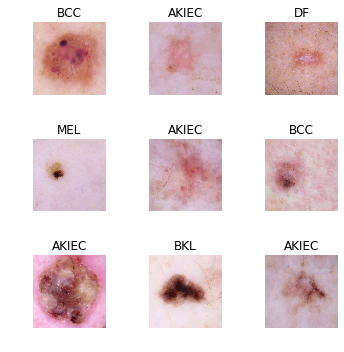

In [6]:
data.show_batch(rows=3, figsize=(5,5))

## Training Resnet18

In [7]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data,models.resnet18,metrics=[accuracy,Precision(),Recall()],callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


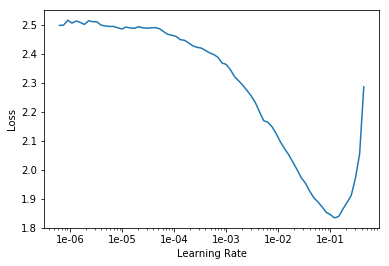

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
def addEarlyStopCallBack(learn):
    learn.callback_fns.append(partial(callbacks.EarlyStoppingCallback, monitor='recall',
                                          min_delta=0.001, patience=10))
addEarlyStopCallBack(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.546032,0.630286,0.757364,0.599734,0.784544,05:04
1,0.413252,0.691956,0.705941,0.662376,0.777078,04:51
2,0.424683,0.648689,0.744383,0.629118,0.759051,04:52
3,0.410543,0.837417,0.700949,0.615332,0.721173,04:53
4,0.413802,0.848031,0.696955,0.676483,0.739128,04:52
5,0.408589,0.685201,0.735397,0.641025,0.798899,04:53
6,0.365654,0.931089,0.683475,0.552250,0.755871,04:52
7,0.334506,0.465584,0.820270,0.749559,0.789395,04:54
8,0.306128,0.629746,0.762856,0.697062,0.768790,04:53
9,0.273331,0.624369,0.772341,0.730716,0.760316,04:53


/opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:178: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


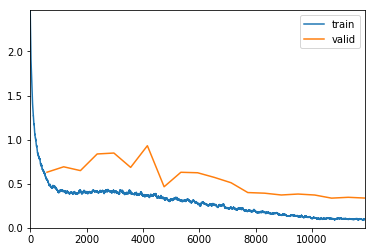

Better model found at epoch 0 with recall value: 0.7845442891120911.
Better model found at epoch 5 with recall value: 0.7988989353179932.
Better model found at epoch 11 with recall value: 0.854004442691803.
Better model found at epoch 16 with recall value: 0.8682435154914856.


In [9]:
lr = 1e-2
learn.fit_one_cycle(20,lr, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='recall', name='stage-1')])

In [10]:
#I think that the model in epoch 19 is better than the one in epoch 16
learn.save('best-stage-1')

In [14]:
learn.load('best-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (38076 items)
x: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: CategoryList
NV,NV,NV,NV,NV
Path: ISIC2018_Task3_Training_Input;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: CategoryList
MEL,MEL,MEL,MEL,MEL
Path: ISIC2018_Task3_Training_Input;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

## Fine Tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


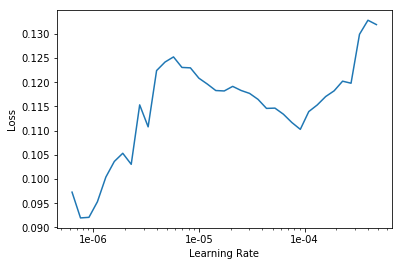

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.111408,0.362155,0.877683,0.817463,0.860623,05:38
1,0.105186,0.357250,0.876186,0.816788,0.859162,05:38


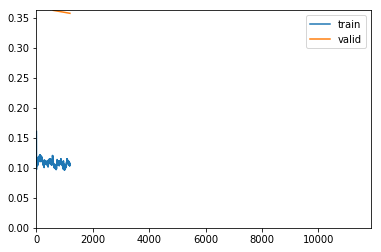

Better model found at epoch 0 with recall value: 0.8606228828430176.


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    se

KeyboardInterrupt: 

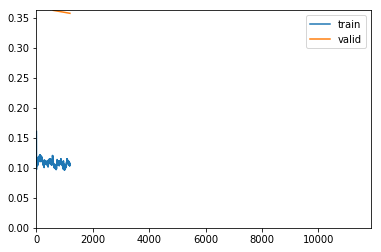

In [15]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr = slice(1e-6,1e-5),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='recall', name='stage-2')])

In [18]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (38076 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
NV,NV,NV,NV,NV
Path: ISIC2018_Task3_Training_Input;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
MEL,MEL,MEL,MEL,MEL
Path: ISIC2018_Task3_Training_Input;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

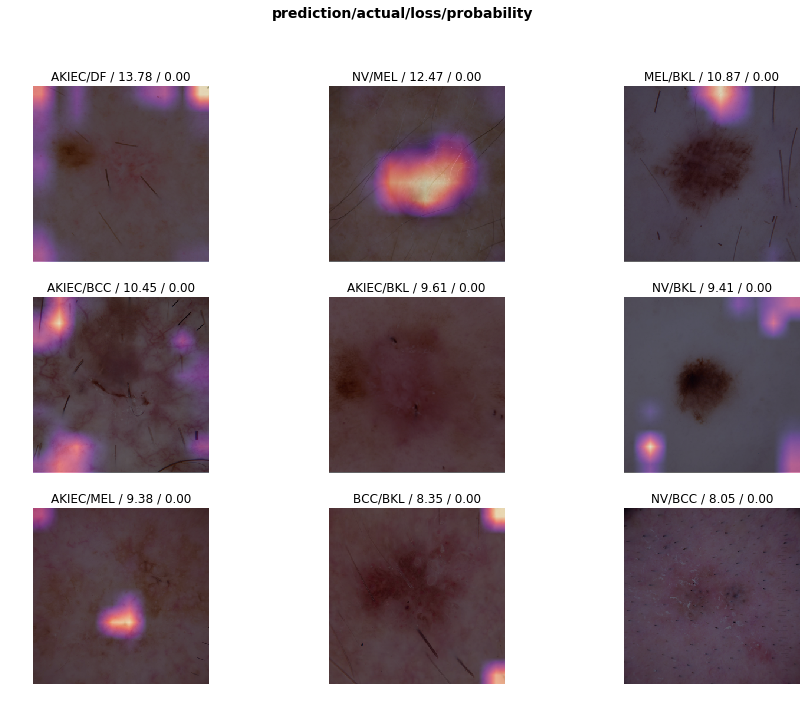

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

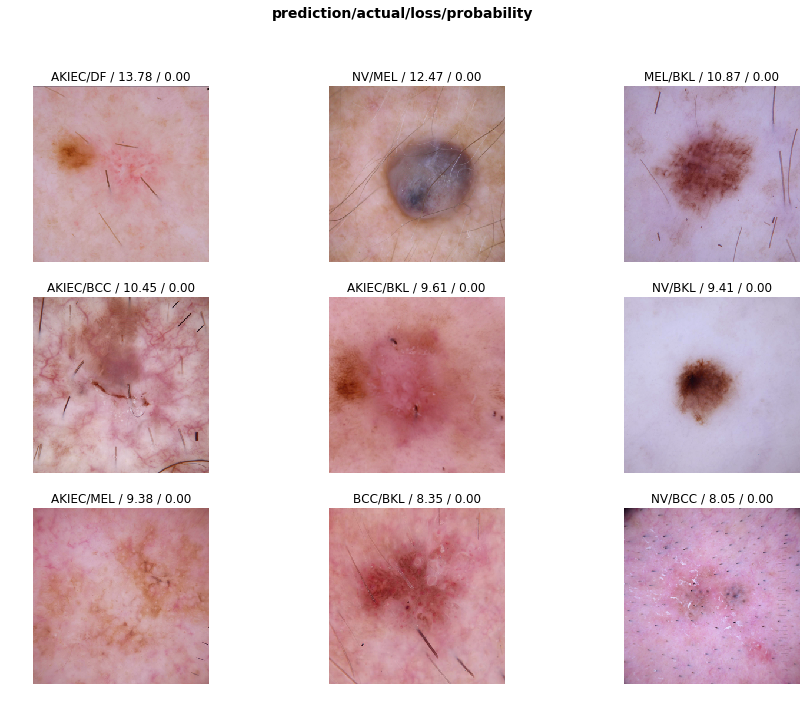

In [21]:
interp.plot_top_losses(9, figsize=(15,11),heatmap=False)

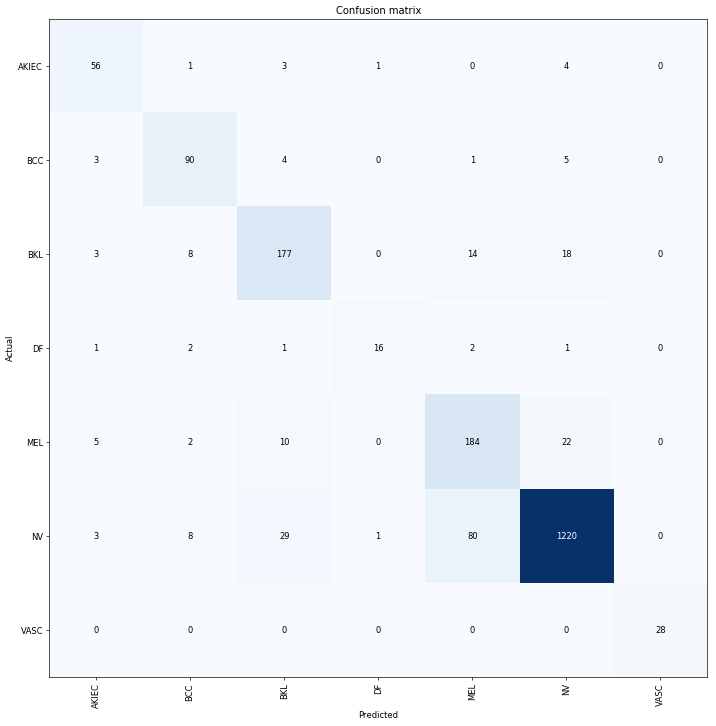

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('NV', 'MEL', 80),
 ('NV', 'BKL', 29),
 ('MEL', 'NV', 22),
 ('BKL', 'NV', 18),
 ('BKL', 'MEL', 14),
 ('MEL', 'BKL', 10),
 ('BKL', 'BCC', 8),
 ('NV', 'BCC', 8),
 ('BCC', 'NV', 5),
 ('MEL', 'AKIEC', 5),
 ('AKIEC', 'NV', 4),
 ('BCC', 'BKL', 4),
 ('AKIEC', 'BKL', 3),
 ('BCC', 'AKIEC', 3),
 ('BKL', 'AKIEC', 3),
 ('NV', 'AKIEC', 3),
 ('DF', 'BCC', 2),
 ('DF', 'MEL', 2),
 ('MEL', 'BCC', 2)]

In [24]:
learn.export()